# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Final

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, May 12th, 2018 at 11:59am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Name: Christopher Hase

### Collaborators: Casey Meehan

# Q1: GLMs with correlation

In Homework 10 you examined the effects of educational attainment and gender on the probability that an indivudal would earn more than $50K per year. However, even the models in the solutions (see Canvas) didn't achieve a perfect fit. Perhaps there was something missing?

## The dataset: A Study of Census Data

In this problem, we are reprising our investigation into the data from the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the UCI Machine Learning Repository).

We'll again want to aggregate the dataset into seven different categories. The categories we wish to consider are:

- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters
- Doctorate
- Some or no high school 

Note that we had to combine some of the existing education categories in your dataframe. For each category, we kept track of a count of the number of males and females who make above (and resp. below) $50k

We provide the code below so that all students begin with the same data structure, names, and global parameters.

In [1]:
import pymc3 as pm
from theano import tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

In [2]:
df = pd.read_csv('census_data.csv')
df.head()

cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']

labels = ["Some HS", "HS Grad", "Some College", "Prof School", "Bachelors", "Masters", "Doctorate"]

categories = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7]
dataset = []
i = 1
for cat in categories:
    filtered = df[df['edu'].isin(cat)]
    dataset.append((i, 0, len(filtered[filtered['sex'] == 'Female']), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '>50K')])))
    dataset.append((i, 1, len(filtered[filtered['sex'] == 'Male']), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '>50K')])))
    i += 1
dataset = np.array(dataset)
dataset = pd.DataFrame(dataset, columns=['category', 'sex', 'total', '<=50', '>50'])
dataset['category'] = dataset['category']-1 #zero indexing
dataset

,category,sex,total,<=50,>50
0,0,0,1321,1298,23
1,0,1,2932,2711,221
2,1,0,3390,3164,226
3,1,1,7111,5662,1449
4,2,0,3227,2974,253
5,2,1,5131,3732,1399
6,3,0,592,483,109
7,3,1,1366,691,675
8,4,0,1619,1280,339
9,4,1,3736,1854,1882


## Part A: Model 1

In Chapter 13.2 McElreath iterates on his model for the UCB admissions data. (See the attached PDF of that section. We have included pdfs of excerpts from McElreath sections 10.1.3 and 13.2)

**A1**: Implement the upgraded model from section 13.2.1 on the income data. You may refer to Osvaldo Martin's pymc3 implementation of Statistical Rethinking if needed.

In [3]:
# hierarchical logit, varying intercept; earn50K ~ education, gender
with pm.Model() as logit_earn50K_educGender:
    
    # priors
    alpha = pm.Normal('alpha', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', 2)
    alpha_educ = pm.Normal('alpha_educ', mu=alpha, sd=sigma, shape=7)
    beta = pm.Normal('beta', mu=0, sd=1)
    
    # model
    p_earn50K = pm.math.invlogit(alpha_educ[np.arange(14)//2] + beta * dataset['sex'])
    
    # likelihood
    earn50K_lik = pm.Binomial('>50_obs', p=p_earn50K, n=dataset['total'], observed=dataset['>50'])

**A2**: You will notice here that the $\alpha$s at different income levels are pooled

1. What criterion do you use to tell if full, partial, or no pooling is appropriate to the given data? 

Before choosing our model, we need to use prior knowledge to posit how related the quantities in our data are. In modeling the impact of gender on income for different educations, we consider how similar we exepct the relation between gender and income to be across all categories. Are there underlying processes that are universal to all categories that influence income or not? No pooling implies that the influence of gender on income is completely independent between degree types. Full pooling suggests that gender influence is identical regardless of degree type. 

Furthermore, pooling may be appropriate in circumstances where one of our categories has sparse data. Even if we expect our categories behave mostly independently, we may wish to have some pooling to regularize the sparse categories for us. 

2. Which type of pooling is implemented here. Why is it most appropriate to our income data?

In this model we use partial pooling. Each class shares the same value of $\beta$, but uses distinct values of $\alpha$. At a first glance, partial pooling is most appropriate, since we anticipate our the influence of gender to be related between categories (it's a societal phenomenon for people of all backgrounds), but not identical between categories (we suppose that people with different educational backgrounds will experience gender discrimination differently). 


**A3**: Sample from the model's posterior and comment on the quality of the samples obtained, examining at least two of the diagnostics discussed in class.

\[Sampling this model took 2 minutes and 30 seconds per chain (~80 it/s) on a VM running on old hardware.\]

In [4]:
# sampling from posterior
with logit_earn50K_educGender:
    logit_50K_educGender_trace = pm.sampling.sample(draws=2000, init='advi', step=pm.NUTS(),
                                                    compute_convergence_checks=True, chains=2,
                                                    target_accept=0.90)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha_educ, sigma_log__, alpha]
100%|██████████| 2500/2500 [00:05<00:00, 466.65it/s]


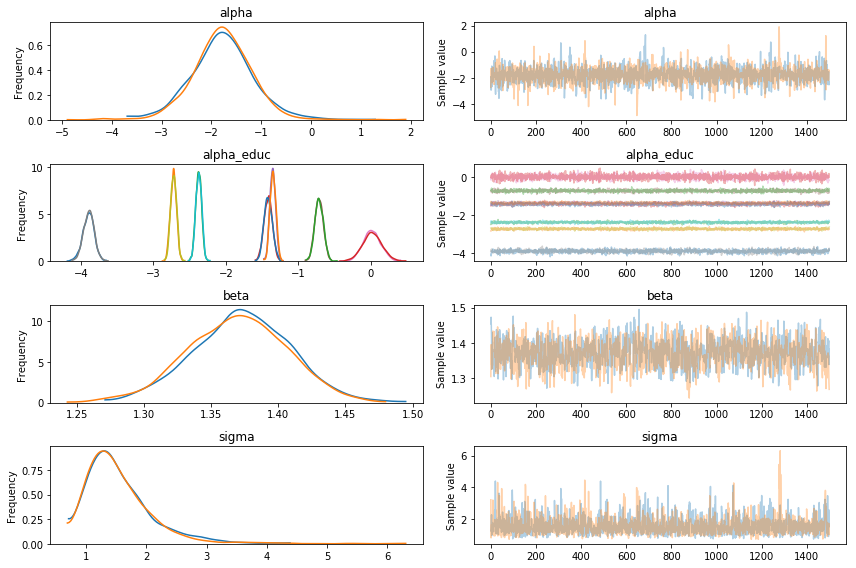

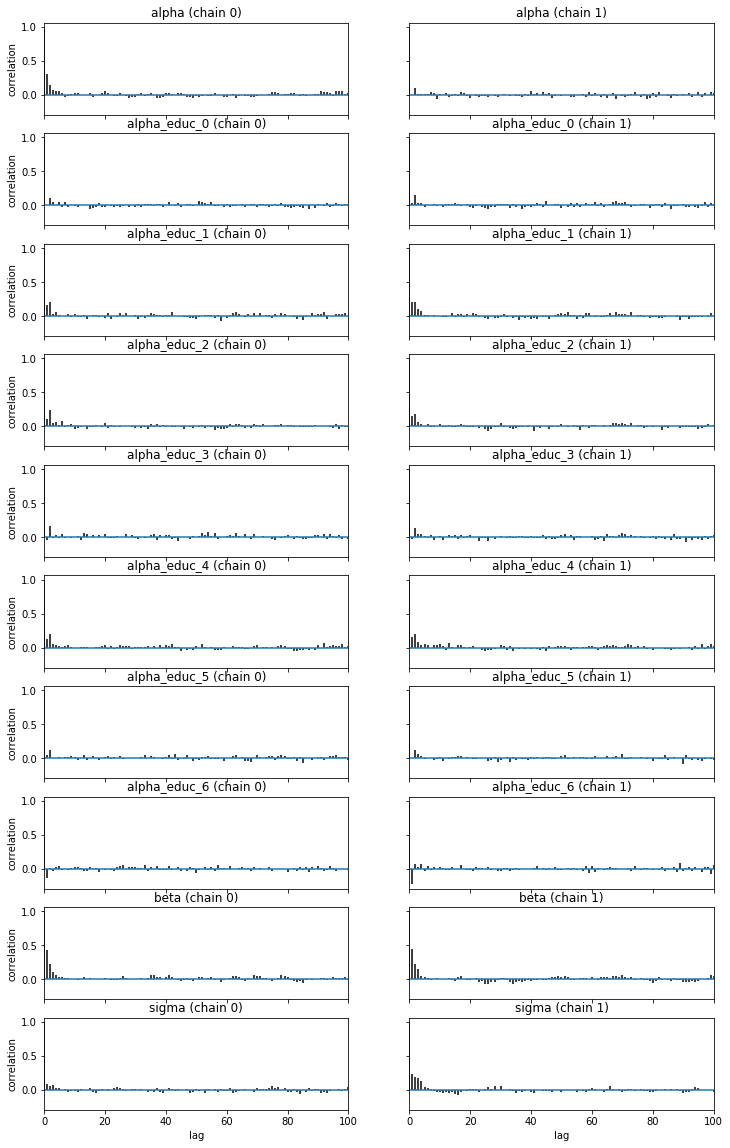

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.776845,0.621307,0.016394,-3.024072,-0.594901,1653.0,0.999688
alpha_educ__0,-3.891952,0.075437,0.001808,-4.041533,-3.742857,1916.0,1.000700
alpha_educ__1,-2.720331,0.040954,0.001208,-2.800494,-2.645718,1325.0,1.002383
alpha_educ__2,-2.373983,0.040335,0.001168,-2.453816,-2.301586,1361.0,1.000579
alpha_educ__3,-1.415472,0.056109,0.001266,-1.527995,-1.310374,2150.0,0.999974
alpha_educ__4,-1.350360,0.039668,0.001193,-1.426573,-1.274861,1029.0,1.002833
alpha_educ__5,-0.712761,0.057843,0.001376,-0.823174,-0.600738,1976.0,1.000680
alpha_educ__6,0.018968,0.125672,0.002364,-0.223940,0.265991,3000.0,1.000259
beta,1.371173,0.036031,0.001226,1.297183,1.437723,843.0,1.004006
sigma,1.558528,0.559063,0.013819,0.752241,2.622356,1415.0,0.999670


In [5]:
# trace plots, auto-correlation plots, and summary
pm.traceplot(logit_50K_educGender_trace[500:])
pm.autocorrplot(logit_50K_educGender_trace[500:])
plt.show()
pm.summary(logit_50K_educGender_trace[500:])

#### Solution to A4)  
We examine our model samples above with two diagnostics: Gelman-Rubin and $n_{eff}$: 
- the Gelman Rubin results are listed under the $\widehat{R}$ of the summary dataframe above. All variables come very close to (within 0.004 of) 1, suggesting that different chains converge similarly. 
- The Geweke test z-scores are shown in the plot immediately above. All z-scores lie within 2 standard deviations of zero, suggesting that each individual chain converges well. 

**A4**: Use the code below to plot the amount of shrinkage in our model. Think carefully about what quantity in the dataset and in the posterior you ought to compare. You should see minimal shrinkage in all categories except the last one.

In [16]:
def shrinkage_plot(observed_log_odds, posterior_means, posterior_sds):
    """
    observed_log_odds - an entry for each category giving the actual log-odds observed log(P(>50K)/(1-P(>50K)))
    posterior_means - an entry for each category giving the mean of the posterior distribution
    posterior_sds - an entry for each category giving the SD of the posterior distribution
    """
    plt.scatter(range(len(observed_log_odds)),observed_log_odds, label='Observed Log Odds', color='orange')
    plt.errorbar(range(len(posterior_means)), posterior_means, yerr = 2*posterior_sds, fmt='o', label='Posterior for Log Odds\n(mean and 2 SDs)',)
    plt.legend(loc='lower right')
    plt.xlabel('Education Category')

<Figure size 504x504 with 0 Axes>

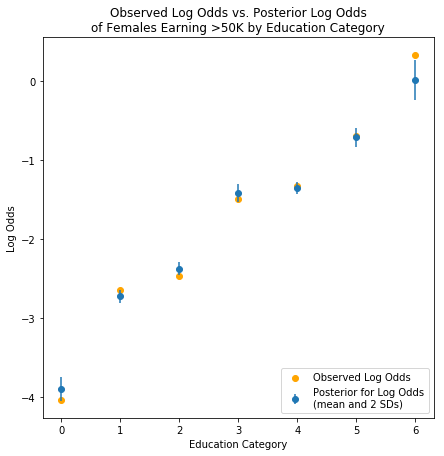

In [17]:
# making shrinkage plot
posteriorMeans_alphaEduc = pm.summary(logit_50K_educGender_trace[500:]).loc[['alpha_educ__0','alpha_educ__1',
                                                                             'alpha_educ__2','alpha_educ__3',
                                                                             'alpha_educ__4','alpha_educ__5',
                                                                             'alpha_educ__6'], 'mean'].values

posteriorSDs_alphaEduc = pm.summary(logit_50K_educGender_trace[500:]).loc[['alpha_educ__0','alpha_educ__1',
                                                                           'alpha_educ__2','alpha_educ__3',
                                                                           'alpha_educ__4','alpha_educ__5',
                                                                           'alpha_educ__6'], 'sd'].values
dataset_female = dataset[dataset['sex']==0]
obs_p_earn50K_female = dataset_female['>50'].values/dataset_female['total'].values
obs_logOdds_earn50K_female = np.log(obs_p_earn50K_female/(1-obs_p_earn50K_female))

plt.figure(figsize=(7, 7))
shrinkage_plot(obs_logOdds_earn50K_female, posteriorMeans_alphaEduc, posteriorSDs_alphaEduc)
plt.title('Observed Log Odds vs. Posterior Log Odds\nof Females Earning >50K by Education Category')
plt.ylabel('Log Odds')
plt.show()

In [20]:
print(obs_logOdds_earn50K_female)
dataset_female

[-4.03308568 -2.63905733 -2.46427364 -1.48866877 -1.32861525 -0.69034998
  0.32850407]


,category,sex,total,<=50,>50
0,0,0,1321,1298,23
2,1,0,3390,3164,226
4,2,0,3227,2974,253
6,3,0,592,483,109
8,4,0,1619,1280,339
10,5,0,536,357,179
12,6,0,86,36,50


In [23]:
#Get standard error of estimators 
dsf = dataset_female.copy()
dsf['SE'] = np.abs(obs_logOdds_earn50K_female / dsf['total'])
dsf

,category,sex,total,<=50,>50,SE
0,0,0,1321,1298,23,0.003053
2,1,0,3390,3164,226,0.000778
4,2,0,3227,2974,253,0.000764
6,3,0,592,483,109,0.002515
8,4,0,1619,1280,339,0.000821
10,5,0,536,357,179,0.001288
12,6,0,86,36,50,0.003820


**A5**: McElreath's new model showed substantial shrinkage within the categories. Why does our model show very minimal shrinkage?. For full credit, include Standard Error in your explanation.

Most categories of our model have large number of samples, and the samples are relatively balanced between categories. Consequently, these categories overwhelm the influence of the prior and of pooling towards each other resulting in minimal shrinkage. This is less true for the 1st and 7th category (some HS and doctorate, respectively) which have much fewer samples. The standard error of the log-odds for these categories are relatively high. As such, the posterior log-odds experience considerable shrinkage towards the prior and towards the the log-odds of other classes. The posterior log-odds for a woman earning >50k for doctorates shrink downards and for 'some-HS' shrink upwards. 

## Part B: Iterating further

After the pooling model above, McElreath builds a model where the alpha and beta in each unit might be correlated (perhaps the higher the admission rate, the less bias there is towards either gender). 

**B1**: Implement the model in 13.2.2. Feel free to use [code from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb) with attribution and understanding (it contains some sweet pymc3 technical wrangling).

The variable names in this model are unchanged and you may re-name them if you wish.

Note that this model builds the a 7 by 2 matrix with alpha values in the first column and beta values in the second. By assumption, the first column and the second column have correlation structure given by the LKJ prior, but there is no explicit correlation among the rows (aside from all the alphas coming from the same mean). In other words, the correlation matrix is 2x2 (not 14x14) and amongst the income-level-free parts of the intercept and slope.

In [24]:
# hierarchical logit, varying slope and intercept; earn50K ~ education, gender
# using Osvaldo Martin code for matrix wrangling:
# https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb
educ_id = dataset['category'].values
with pm.Model() as logit_earn50K_educGender2:
    
    sd_dist = pm.HalfCauchy.dist(2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_educ', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    alpha_beta_educ = pm.MvNormal('alpha_beta_educ', mu=tt.stack([alpha, beta]), chol=chol, 
                                  shape=(len(categories), 2))
    
    alpha_educ = pm.Deterministic('alpha_educ', alpha_beta_educ[:, 0])
    beta_educ = pm.Deterministic('beta_educ', alpha_beta_educ[:, 1])
    
    # model
    p_earn50K = pm.math.invlogit(alpha_educ[educ_id] + beta_educ[educ_id] * dataset['sex'])
    
    # likelihood
    earn50K_lik = pm.Binomial('>50_obs', p=p_earn50K, n=dataset['total'], observed=dataset['>50'])

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes 10 minutes per chain on a VM on old hardware and 2 minutes 30 seconds on a recent-gen Mac). Analyze at least two diagnostics and comment on the quality of the samples obtained.

In [67]:
# sampling from posterior
with logit_earn50K_educGender2:
    logit_50K_educGender_trace2 = pm.sampling.sample(draws=3000, tune=2000, init='advi', step=pm.NUTS(),
                                                     compute_convergence_checks=True, chains=2,
                                                     target_accept=0.95)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_beta_educ, beta, alpha, chol_cov_cholesky_cov_packed__]
100%|██████████| 5000/5000 [00:54<00:00, 92.01it/s] 
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


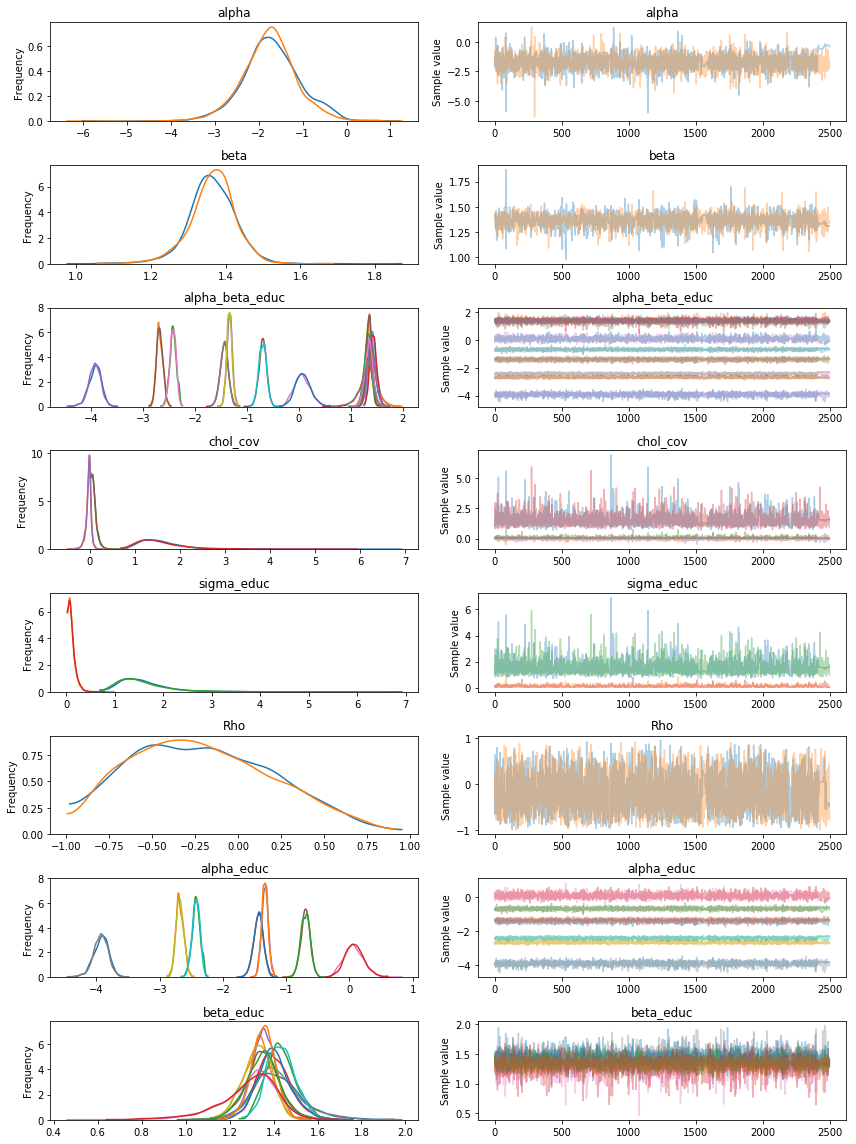

In [68]:
# trace plots, auto-correlation plots, and summary
pm.traceplot(logit_50K_educGender_trace2[500:])
plt.show()

In [94]:
summ = pm.summary(logit_50K_educGender_trace2[500:])
summ['n_eff_frac'] = summ['n_eff']/5000
print(summ['n_eff_frac'].mean())
summ

0.384994444444


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat,n_eff_frac
alpha,-1.737251,0.647690,0.020009,-2.967313,-0.375980,321.0,1.000763,0.0642
beta,1.363459,0.064345,0.001304,1.236598,1.485351,2563.0,0.999835,0.5126
alpha_beta_educ__0_0,-3.932139,0.121617,0.002424,-4.171641,-3.697716,2543.0,1.000547,0.5086
alpha_beta_educ__0_1,1.415603,0.114933,0.002525,1.188944,1.651439,2361.0,1.000188,0.4722
alpha_beta_educ__1_0,-2.681029,0.061741,0.001339,-2.794723,-2.557050,1682.0,1.000304,0.3364
alpha_beta_educ__1_1,1.325321,0.065669,0.001428,1.193128,1.448087,1655.0,0.999800,0.3310
alpha_beta_educ__2_0,-2.425506,0.062120,0.001940,-2.545809,-2.304108,603.0,0.999863,0.1206
alpha_beta_educ__2_1,1.434709,0.066647,0.002054,1.305358,1.564147,704.0,0.999954,0.1408
alpha_beta_educ__3_0,-1.438419,0.077910,0.001393,-1.587815,-1.282373,2738.0,0.999802,0.5476
alpha_beta_educ__3_1,1.400306,0.078503,0.001585,1.238257,1.554776,2406.0,0.999842,0.4812


/anaconda3/envs/python3/lib/python3.6/site-packages/pymc3/diagnostics.py:89: RuntimeWarning: Mean of empty slice.
  z = first_slice.mean() - last_slice.mean()
/anaconda3/envs/python3/lib/python3.6/site-packages/pymc3/diagnostics.py:90: RuntimeWarning: Degrees of freedom <= 0 for slice
  z /= np.sqrt(first_slice.var() + last_slice.var())


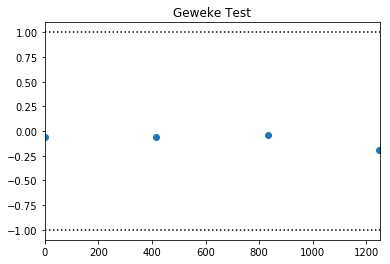

In [83]:
#Run a Geweke Test to check convergence 
from pymc3 import geweke
z = geweke(logit_50K_educGender_trace2[500:], intervals=4)
plt.scatter(*z[0]['alpha'].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 1250)
plt.title('Geweke Test')
plt.show()

#### Solution Part B2: 
As with part A3, we consider Gelman-Rubin and a Geweke test. Ther gelman rubin results, listed under $\widehat{R}$ of the summary table are all within 0.002 of 1, suggesting that different chains are converging similarly. 

The Geweke test, although only 4 intervals is similarly promising, all z-tests land within 2 stand deviations of 0. This suggests that each individual trace converges nicely.  

**B3**: Propose at least two methods of improving the quality of the samples obtained and explain how/why each method would help. For **some extra credit** implement these.

#### Solution B3
2 ways we can improve the quality of our samples are: 
- 1) Parameter tuning: If $n_{eff}$ is low or our sampler experiences a high number of divergences, we may need to modify the parameters our sampler operates with. First, we may increase the target_accept value. The sampler will modify its step size to achieve an acceptance rate approximately equal to this value. A higher acceptance rate corresponds to a slower moving, more cautious sampler. Second, we may increase the number of tuning steps taken. This gives the sampler more time to optimize its internal parameters, like proposal step size. Third, we may simply increase the number of draws taken. If we give the sampler a high target_accept, it may be a good idea to increase the amount of tuning and number of draws for it to optimize its step size and explore the whole space. 

- 2) Reparameterization: we may also wish to reparameterize our model so it is *statistially* equivalent, but specified differently. But expressing certain variables as deterministic transformations between model layers, we can leave certain actively sampled variables uncorrelated. This can effectively decrease the curvature of our space, which will likely reduce divergences and improve sample qualities without compromising the actual statistical model. 

Below, we experiment with parameter tuning to achieve a better $n_{eff}$. 

In [87]:
# sampling from posterior
with logit_earn50K_educGender2:
    logit_50K_educGender_trace_improve = pm.sampling.sample(draws=6000, tune=10000, init='advi', step=pm.NUTS(),
                                                     compute_convergence_checks=True, chains=2,
                                                     target_accept=0.99)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha_beta_educ, beta, alpha, chol_cov_cholesky_cov_packed__]
100%|██████████| 16000/16000 [02:55<00:00, 91.19it/s] 
There were 614 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.651269552832, but should be close to 0.8. Try to increase the number of tuning steps.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [93]:
summ = pm.summary(logit_50K_educGender_trace_improve[500:])
summ['n_eff_frac'] = summ['n_eff']/5000
print(summ['n_eff_frac'].mean())
summ

0.427272222222


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat,n_eff_frac
alpha,-1.759722,0.613660,0.011740,-2.947460,-0.518265,2241.0,0.999912,0.4482
beta,1.363242,0.064341,0.001268,1.232623,1.488306,2732.0,0.999977,0.5464
alpha_beta_educ__0_0,-3.929345,0.122311,0.002223,-4.172076,-3.688171,2792.0,1.001264,0.5584
alpha_beta_educ__0_1,1.412125,0.114593,0.001877,1.195750,1.660511,3608.0,1.000961,0.7216
alpha_beta_educ__1_0,-2.684144,0.061756,0.001629,-2.790137,-2.551669,932.0,1.001104,0.1864
alpha_beta_educ__1_1,1.330112,0.065662,0.001905,1.192392,1.445210,731.0,1.000881,0.1462
alpha_beta_educ__2_0,-2.419926,0.059434,0.001343,-2.541130,-2.303389,1583.0,0.999936,0.3166
alpha_beta_educ__2_1,1.428072,0.064317,0.001518,1.298688,1.552750,1411.0,1.000917,0.2822
alpha_beta_educ__3_0,-1.434194,0.076956,0.001824,-1.602450,-1.298303,1417.0,1.002999,0.2834
alpha_beta_educ__3_1,1.396061,0.076101,0.001215,1.243910,1.550461,3852.0,1.000759,0.7704


In [18]:
## sampling from posterior
with logit_earn50K_educGender2:
    logit_50K_educGender_trace_improve = pm.sampling.sample(draws=2000, init='advi', step=pm.NUTS(),
                                                     compute_convergence_checks=True, chains=2, tune=10000,
                                                     target_accept=0.99)

Sequential sampling (2 chains in 1 job)
NUTS: [alpha_beta_educ, beta, alpha, chol_cov_cholesky_cov_packed__]
100%|██████████| 12000/12000 [07:50<00:00, 25.53it/s]
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


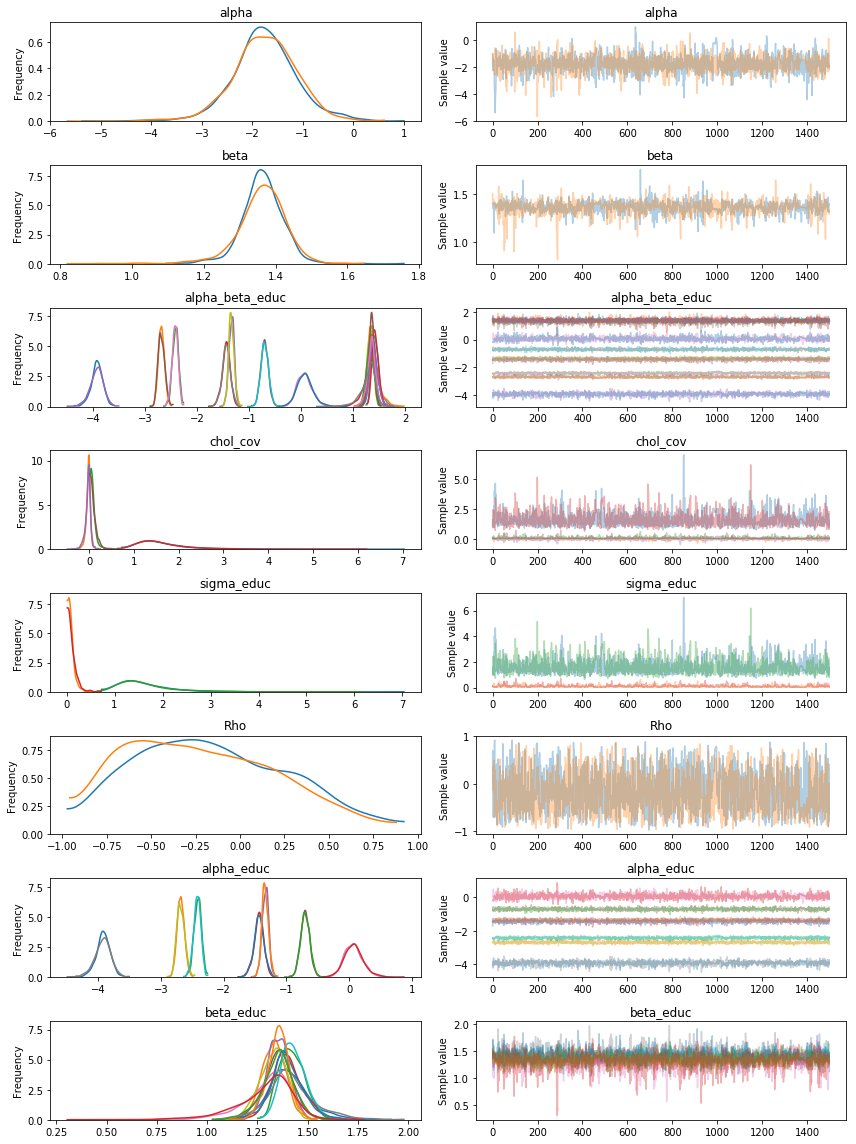

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-1.752111,0.639600,0.017234,-3.040985,-0.531648,1116.0,0.999667
beta,1.361782,0.066094,0.001856,1.241316,1.494103,1176.0,1.000415
alpha_beta_educ__0_0,-3.927832,0.121771,0.002766,-4.188462,-3.704020,1722.0,1.000319
alpha_beta_educ__0_1,1.411499,0.115871,0.002804,1.188861,1.670695,1482.0,1.001831
alpha_beta_educ__1_0,-2.684071,0.060841,0.001880,-2.793431,-2.557364,966.0,0.999667
alpha_beta_educ__1_1,1.328928,0.064148,0.002034,1.196717,1.449397,896.0,0.999726
alpha_beta_educ__2_0,-2.419126,0.058079,0.001828,-2.528343,-2.306238,846.0,1.003995
alpha_beta_educ__2_1,1.426737,0.062719,0.002055,1.311893,1.549182,771.0,1.004586
alpha_beta_educ__3_0,-1.437781,0.079641,0.001843,-1.597966,-1.277850,1870.0,0.999819
alpha_beta_educ__3_1,1.399319,0.080092,0.001902,1.256689,1.582584,1587.0,0.999707


In [19]:
# trace plots, auto-correlation plots, and summary
pm.traceplot(logit_50K_educGender_trace_improve[500:])
plt.show()
pm.summary(logit_50K_educGender_trace_improve[500:])

**B4**: Regardless of your answer above, assume the samples are valid and give an analysis of whether the data and models support the hypothesis that males are more advantaged in lower income categories than they are in higher income categories. For full credit, include at least one formal model comparison or probability analysis.

In [39]:
# get WAIC
def make_compare(names, traces, models, ic='WAIC'):
    comparedf = pm.compare(traces, models, method='pseudo-BMA')
    temp = comparedf.sort_index()
    temp['Model'] = names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf
 
names = ['Fixed male', 'Vary male']
dfc = make_compare(names, [logit_50K_educGender_trace[500:], logit_50K_educGender_trace_improve[500:]],
                          [logit_earn50K_educGender, logit_earn50K_educGender2])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
Vary male,121.64,6.21,0,0.73,4.95,0,1
Fixed male,123.62,6.26,1.99,0.27,5.8,1.7,1


**B5**: Regardless of your answer above, assume the samples are valid and give an analysis of: 
1. The posterior probability that males with a Bachelor's degree are more likely to have high incomes than males with a Professional School degree (education categories 5 and 4) \[Specifically, how certain is it that one or the other class has a higher chance of having a high income?\]. 
2. The posterior-predictive on the number of female PhDs earning more than 50K in similarly sized samples

In [35]:
p50k_cat4_m = expit(logit_50K_educGender_trace2['beta_educ'][:, 3]+logit_50K_educGender_trace2['alpha_educ'][:, 3])
p50k_cat5_m = expit(logit_50K_educGender_trace2['beta_educ'][:, 4]+logit_50K_educGender_trace2['alpha_educ'][:, 4])
np.sum(p50k_cat5_m > p50k_cat4_m)/len(p50k_cat5_m)

0.82699999999999996

In [40]:
with logit_earn50K_educGender:
    postPred_p_earn50K_educGender = pm.sample_ppc(logit_50K_educGender_trace[500:], samples=5000)

100%|██████████| 5000/5000 [00:04<00:00, 1055.70it/s]


In [41]:
with logit_earn50K_educGender2:
    postPred_p_earn50K_educGender2 = pm.sample_ppc(logit_50K_educGender_trace2[500:], samples=5000)

100%|██████████| 5000/5000 [00:03<00:00, 1318.78it/s]


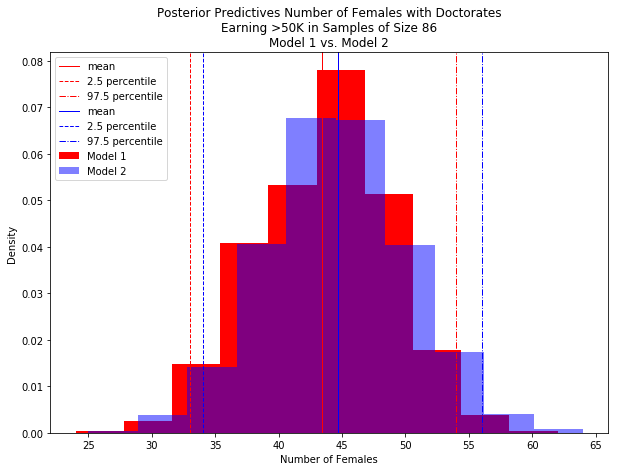

In [55]:
postPred_cat7_100female2 = postPred_p_earn50K_educGender2['>50_obs'][:, 12]
postPred_cat7_100female_mean2 = np.mean(postPred_cat7_100female2)
postPred_cat7_100female_025_2 = np.percentile(postPred_cat7_100female2, 2.5)
postPred_cat7_100female_975_2 = np.percentile(postPred_cat7_100female2, 97.5)

postPred_cat7_100female = postPred_p_earn50K_educGender['>50_obs'][:, 12]
postPred_cat7_100female_mean = np.mean(postPred_cat7_100female)
postPred_cat7_100female_025 = np.percentile(postPred_cat7_100female, 2.5)
postPred_cat7_100female_975 = np.percentile(postPred_cat7_100female, 97.5)



plt.figure(figsize=(10, 7))
plt.axvline(postPred_cat7_100female_mean, color='red', linestyle='solid', linewidth=1, label='mean')
plt.axvline(postPred_cat7_100female_025, color='red', linestyle='dashed', linewidth=1, label='2.5 percentile')
plt.axvline(postPred_cat7_100female_975, color='red', linestyle='dashdot', linewidth=1, label='97.5 percentile')
plt.axvline(postPred_cat7_100female_mean2, color='blue', linestyle='solid', linewidth=1, label='mean')
plt.axvline(postPred_cat7_100female_025_2, color='blue', linestyle='dashed', linewidth=1, label='2.5 percentile')
plt.axvline(postPred_cat7_100female_975_2, color='blue', linestyle='dashdot', linewidth=1, label='97.5 percentile')
plt.legend(loc='upper left', labels = ['mean', '2.5 percentile', '97.5 percentile'])
plt.hist(postPred_cat7_100female, density=True, color='red', label='Model 1')
plt.hist(postPred_cat7_100female2, density=True, color='blue', alpha=0.5, label='Model 2')
plt.legend(loc='upper left')
plt.xlabel('Number of Females')
plt.ylabel('Density')
plt.title('Posterior Predictives Number of Females with Doctorates\nEarning >50K in Samples of Size 86\nModel 1 vs. Model 2')
plt.show()

# Q2: Using Mixture of Experts and Mixture Density Networks to Solve Inverse Problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail.

We read this data in...

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from theano import tensor as T
import theano
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
df = pd.read_csv("one-to-many.csv")
df.head()

,target,x
0,0.000000,0.018727
1,0.001001,0.050424
2,0.002002,0.042375
3,0.003003,0.038596
4,0.004004,0.019352


...and then plot it. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

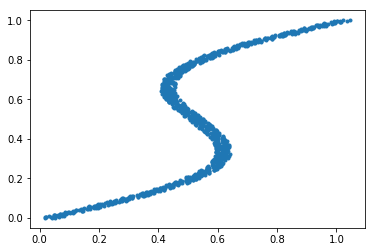

In [94]:
plt.plot(df.x, df.target, '.');

Normal regression approaches to modeling such a function wont work, as they expect the function to be a proper mathematical function, that is, single valued.

These kind of problems are called **inverse problems**, where more than one input state leads to an output state, and we have to try and model these multiple input states.

A mixture of gaussians (or other distributions) might is a sensible way to do this.

You choose one of the gaussians with some probability. The mean of the gaussian is then given by some regression function, say for example a straight line. We could additionally fix the standard deviation or model it as well. 

Thus, for each component Gaussian, we choose a functional form for the mean and standard deviation. So our model looks something like this:

$$f(x)  = \sum_i \lambda_i g_i (x) $$

Say we fit a model with 3 gaussians to this data. Such a model cannot fit the function above. Notice for example that at $x=0.2$ only one of the gaussians will dominate, different from the situation at $x=0.5$. This means that the probabilities of "belonging" to one or the other gaussians is also changing with $x$.

If we allow the mixing probabilities to depend on $x$, we can model this situation.

$$f(x)  = \sum_i \lambda_i (x) g_i (x) $$

Such a model is called a "mixture of experts" model. The idea is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector.

You can think of this model as implementing a "standard" gaussian mixture at each "point" x, with the added complexity that all of the means, standard deviations, and mixture probabilities change from one x to another.

See https://www.cs.toronto.edu/~hinton/absps/hme.pdf and http://www.ee.hacettepe.edu.tr/~eyuksel/Publications/2012_TwentyYearsofMixtureofExperts.pdf for more details. I found the latter clearer and easier to understand.

For this entire question you might find diagram code from [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) useful. Take with attribution.

We will assume we have **3 gaussians**.

## PART A: Iterative Linear Regression

The basic idea, illustrated below, is to fit piecewise linear regressions iteratively in a EM style algorithm.

![](images/mixreg0.png)

The algorithm looks like this: initialize the 1000 points in this dataset as randomly belonging to one of 3 "classes" or "clusters" or "experts". This takes a x-data problem and augments it with a fake z data point that tells us whether the point belongs in cluster 0, 1, or 2. (It helps convergence to say that points in the leftmost 0.2 belong to cluster 0 and righmost 0.2 to cluster 2).

Once we have the fake z data we can separate out the 1000 points into 3 sets of points and fit 3 linear regression models. 

We can make predictions for all 1000 points on the data for each of the 3 regression lines. We now assign a data point to the cluster by calculating the squared distances between its actual y value and the 3 cluster predictions and choosing the smallest one.

We then rinse and repeat.

**A1** Implement this algorithm along with a convergence criterion of your choice

In [95]:
# fitting piecewise linear regressions iteratively in a EM style algorithm
# convergence criterion: clusters don't change
np.random.seed(1)
kmeans = KMeans(n_clusters=3, random_state=1).fit(df['x'].values.reshape(len(df), -1))
clusters = np.random.choice(np.arange(3), len(df), replace=True)
new_clusters = kmeans.labels_
while np.sum(clusters==new_clusters) != len(clusters):
    df_clust = df.copy(deep=True)
    df_clust['cluster'] = pd.Series(new_clusters, index=df.index)
    df0 = df_clust[df_clust['cluster'] == 0]
    df1 = df_clust[df_clust['cluster'] == 1]
    df2 = df_clust[df_clust['cluster'] == 2]
    lin_reg0 = LinearRegression(fit_intercept=True, normalize=False)
    lin_reg1 = LinearRegression(fit_intercept=True, normalize=False)
    lin_reg2 = LinearRegression(fit_intercept=True, normalize=False)
    lin_reg0.fit(df0['x'].values.reshape(len(df0), -1), df0['target'])
    lin_reg1.fit(df1['x'].values.reshape(len(df1), -1), df1['target'])
    lin_reg2.fit(df2['x'].values.reshape(len(df2), -1), df2['target'])
    pred0 = lin_reg0.predict(df['x'].values.reshape(len(df), -1))
    pred1 = lin_reg1.predict(df['x'].values.reshape(len(df), -1))
    pred2 = lin_reg2.predict(df['x'].values.reshape(len(df), -1))
    sqres0 = ((pred0 - df['target'])**2).values.reshape(len(df), -1)
    sqres1 = ((pred1 - df['target'])**2).values.reshape(len(df), -1)
    sqres2 = ((pred2 - df['target'])**2).values.reshape(len(df), -1)
    sqres_mat = np.concatenate([sqres0, sqres1, sqres2], axis=1)
    clusters = new_clusters.copy()
    new_clusters = np.argmin(sqres_mat, axis=1)

**A2** Produce a diagram like the one above which illustrates the straight line fits as well as the cluster belonging.

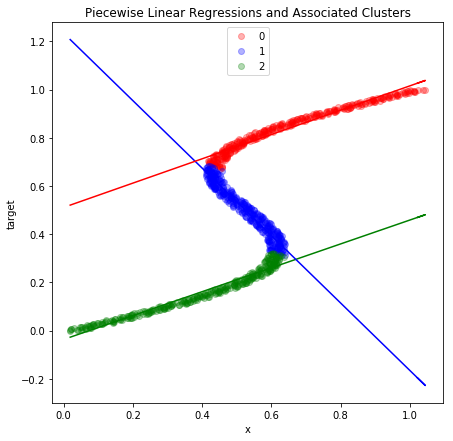

In [96]:
# plotting linear regressions and associated clusters
plt.figure(figsize=(7, 7))
plt.plot(df2['x'], df2['target'], 'o', color='red', alpha=0.3)
plt.plot(df1['x'], df1['target'], 'o', color='blue', alpha=0.3)
plt.plot(df0['x'], df0['target'], 'o', color='green', alpha=0.3)
plt.legend(loc='upper center', labels=['0', '1', '2'])
plt.plot(df['x'], pred0, color='green')
plt.plot(df['x'], pred1, color='blue')
plt.plot(df['x'], pred2, color='red')
plt.xlabel('x')
plt.ylabel('target')
plt.title('Piecewise Linear Regressions and Associated Clusters')
plt.show()

In this part we'll construct a gaussian mixture model of 3 "expert" linear regressions. The idea is to create a fit which looks like this:

![](images/mixreg.png)

Here again the three regression lines work in different regions of $f$. We want a principled way to sample from this model and to be able to produce posterior and posterior-predictive regions.

There are 3 parts to this model. First the means of the gaussians in the mixture are modeled with linear regression as shown in the picture above. We will also model $log(\sigma)$ for each gaussian in the mixture as a linear regression as well ($\sigma$ needs to be positive).

We now need to model the mixture probabilities, i.e., the probabilities required to choose one or the other gaussian. We'll model these probabilities i.e. the $\lambda$s using softmax regression (ie do a linear regression and softmax it to get 3 probabilities).

**B1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

In [30]:
# define model
x = theano.shared(df.x.values.reshape(len(df), -1))
target = theano.shared(df.target.values)

np.random.seed(1)
init_h_target = np.random.randn(1, 3)
init_h_class = np.random.randn(1, 3)
init_h_sigma = np.random.randn(1, 3)

with pm.Model() as experts:
    
    # weights from input to hidden and hidden to output
    w_h_target = pm.Normal('w_h_target', mu=0, sd=5, shape=(1, 3), testval=init_h_target)
    w_h_class = pm.Normal('w_h_class', mu=0, sd=5, shape=(1, 3), testval=init_h_class)
    w_h_sigma = pm.Normal('w_h_sigma', mu=0, sd=5, shape=(1, 3), testval=init_h_sigma)
    
    # biases for input to hiddena and hidden to output
    b_h_target = pm.Normal('b_h_target', mu=0, sd=5, shape=(1, 3))
    b_h_class = pm.Normal('b_h_class', mu=0, sd=5, shape=(1, 3))
    b_h_sigma = pm.Normal('b_h_sigma', mu=0, sd=5, shape=(1, 3))
    
    # outputs
    target = pm.Deterministic('means', T.dot(x, w_h_target) + b_h_target)
    classes = pm.Deterministic('probs', T.nnet.softmax(T.dot(x, w_h_class) + b_h_class))
    sigma = pm.Deterministic('sigmas', T.exp(T.dot(x, w_h_sigma) + b_h_sigma) + 0.01)
    
    
    obs = pm.NormalMixture('obs', w=act_class, mu=act_target, sd=act_sigma, observed=target)

**B2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

In [31]:
# fit model variationally
with experts:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference, obj_optimizer=pm.adam(learning_rate=0.01))
    experts_trace = approx.sample(draws=5000)

Average Loss = -1,608.1: 100%|██████████| 50000/50000 [02:57<00:00, 280.91it/s]
Finished [100%]: Average Loss = -1,608.2


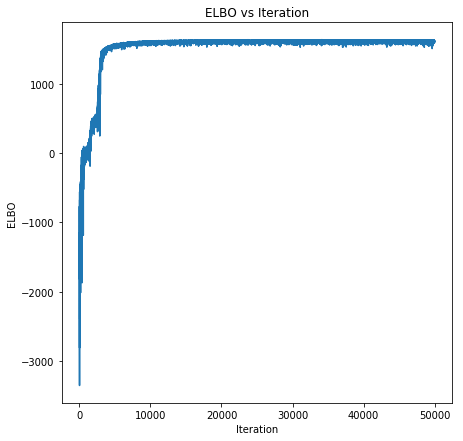

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w_h_target__0_0,0.422737,2.076457e-03,3.255528e-05,0.418734,0.426735
w_h_target__0_1,-1.543995,3.498437e-03,5.692864e-05,-1.550970,-1.537373
w_h_target__0_2,0.420362,8.983885e-04,1.414672e-05,0.418646,0.422124
w_h_class__0_0,-8.442073,1.882853e-01,2.779746e-03,-8.797038,-8.073217
w_h_class__0_1,-0.004886,1.388367e-01,2.095620e-03,-0.274081,0.268085
w_h_class__0_2,8.081300,1.493491e-01,2.070903e-03,7.778713,8.367361
w_h_sigma__0_0,18.739119,1.890471e-01,2.935547e-03,18.369782,19.109834
w_h_sigma__0_1,1.235491,1.367937e-01,1.900750e-03,0.972070,1.507123
w_h_sigma__0_2,-20.133531,1.988393e-01,2.845618e-03,-20.496838,-19.736319
b_h_target__0_0,-0.018195,8.343054e-04,1.106395e-05,-0.019815,-0.016534


In [69]:
# ELBO plot
plt.figure(figsize=(7, 7))
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('Iteration')
plt.title('ELBO vs Iteration')
plt.show()

# summary
pm.summary(experts_trace[500:])

### Note that pm.traceplot kills my kernel, so I did not run it.

**B3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the means with standard deviations showing their uncertainty overlaid on the data.

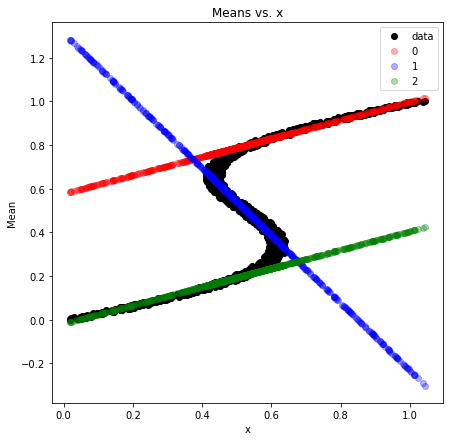

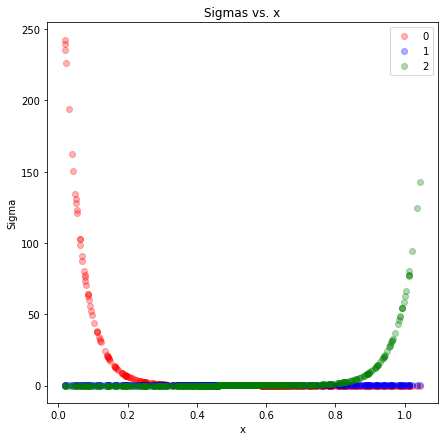

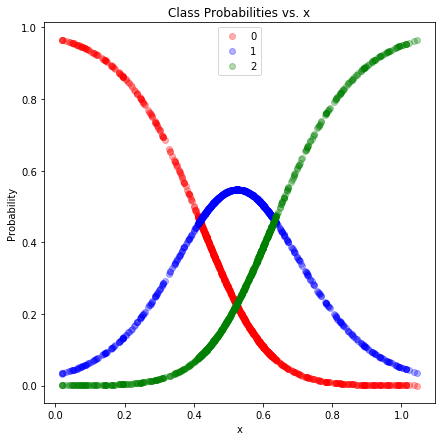

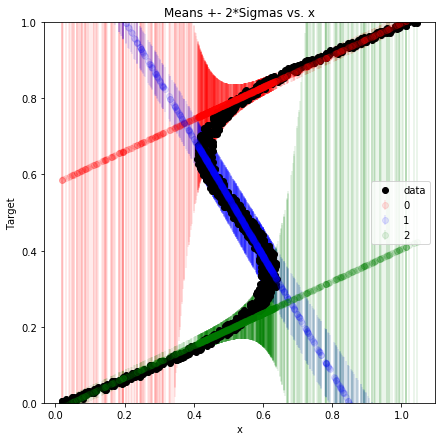

In [144]:
# plotting means and sigmas against x
means0 = pm.summary(experts_trace)['mean'][18:3018][::3].values
means1 = pm.summary(experts_trace)['mean'][19:3019][::3].values
means2 = pm.summary(experts_trace)['mean'][20:3020][::3].values

sigmas0 = pm.summary(experts_trace)['mean'][6018:][::3].values
sigmas1 = pm.summary(experts_trace)['mean'][6019:][::3].values
sigmas2 = pm.summary(experts_trace)['mean'][6020:][::3].values

probs0 = pm.summary(experts_trace)['mean'][3018:6018][::3].values
probs1 = pm.summary(experts_trace)['mean'][3019:6019][::3].values
probs2 = pm.summary(experts_trace)['mean'][3020:6020][::3].values

plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black', label='data')
plt.plot(df.x.values, means2, 'o', color='red', label=0, alpha=0.3)
plt.plot(df.x.values, means1, 'o', color='blue', label=1, alpha=0.3)
plt.plot(df.x.values, means0, 'o', color='green', label=2, alpha=0.3)
plt.xlabel('x')
plt.ylabel('Mean')
plt.title('Means vs. x')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(df.x.values, sigmas2, 'o', color='red', label=0, alpha=0.3)
plt.plot(df.x.values, sigmas1, 'o', color='blue', label=1, alpha=0.3)
plt.plot(df.x.values, sigmas0, 'o', color='green', label=2, alpha=0.3)
plt.xlabel('x')
plt.ylabel('Sigma')
plt.title('Sigmas vs. x')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(df.x.values, probs0, 'o', color='red', label=0, alpha=0.3)
plt.plot(df.x.values, probs1, 'o', color='blue', label=1, alpha=0.3)
plt.plot(df.x.values, probs2, 'o', color='green', label=2, alpha=0.3)
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('Class Probabilities vs. x')
plt.legend(loc='upper center')
plt.show()

# plotting like above
plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black', label='data')
plt.errorbar(df.x.values, means2, yerr = 2*sigmas2, fmt='o', color='red', alpha=0.1, label=0)
plt.errorbar(df.x.values, means1, yerr = 2*sigmas1, fmt='o', color='blue', alpha=0.1, label=1)
plt.errorbar(df.x.values, means0, yerr = 2*sigmas0, fmt='o', color='green', alpha=0.1, label=2)
plt.title('Means +- 2*Sigmas vs. x')
plt.xlabel('x')
plt.ylabel('Target')
plt.ylim(0, 1)
plt.legend(loc='center right')
plt.show()

**B4** Plot the posterior predictive (mean and variance) as a function of x for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

In [45]:
# sampling from posterior predictive
with experts:
    expert_pp = pm.sample_ppc(experts_trace, samples=5000)

100%|██████████| 5000/5000 [05:16<00:00, 15.82it/s]


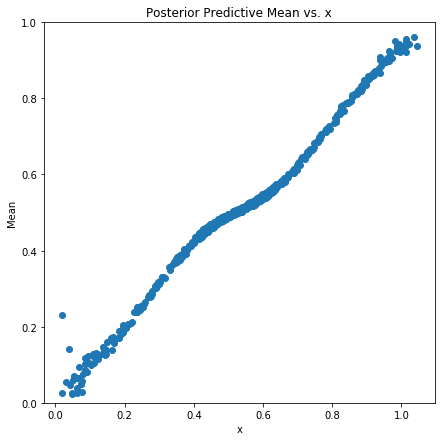

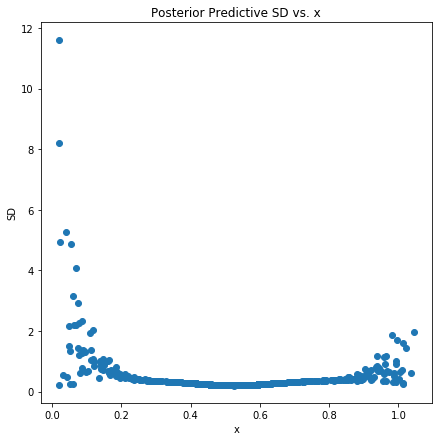

In [66]:
# plotting posterior predictive means +- 2*sd
plt.figure(figsize=(7, 7))
plt.plot(df.x.values, np.mean(expert_pp['obs'], axis=0), 'o')
plt.xlabel('x')
plt.ylabel('Mean')
plt.title('Posterior Predictive Mean vs. x')
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(df.x.values, np.std(expert_pp['obs'], axis=0), 'o')
plt.xlabel('x')
plt.ylabel('SD')
plt.title('Posterior Predictive SD vs. x')
plt.show()

**B5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. This diagram may look something like this:

![](images/mixpred.png)

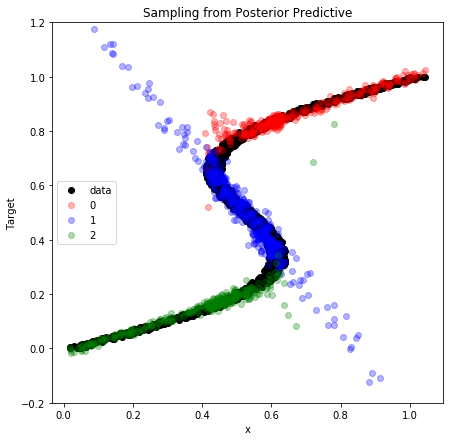

In [100]:
# sampling from posterior predictive
np.random.seed(1)
class_nums = []
pred_mat = np.zeros((len(df), 3))
for i in range(len(df)):
    gaussian_draw0 = np.random.normal(loc=means0[i], scale=sigmas0[i])
    gaussian_draw1 = np.random.normal(loc=means1[i], scale=sigmas1[i])
    gaussian_draw2 = np.random.normal(loc=means2[i], scale=sigmas2[i])
    gaussian_draws = np.array([gaussian_draw0, gaussian_draw1, gaussian_draw2])
    classes_ind = np.random.multinomial(n=1, pvals=[probs0[i], probs1[i], probs2[i]])
    pred_mat[i, :] = gaussian_draws*classes_ind
    class_num = np.argmax(classes_ind)
    class_nums.append(class_num)
class_nums = np.array(class_nums)

class_df = np.concatenate([df.values, class_nums.reshape(len(df), -1)], axis=1)
x_class0 = class_df[class_df[:, 2] == 0, 1]
x_class1 = class_df[class_df[:, 2] == 1, 1]
x_class2 = class_df[class_df[:, 2] == 2, 1]
pred0 = pred_mat[class_df[:, 2] == 0, 0]
pred1 = pred_mat[class_df[:, 2] == 1, 1]
pred2 = pred_mat[class_df[:, 2] == 2, 2]

plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black')
plt.plot(x_class2, pred2, 'o', color='red', alpha=0.3)
plt.plot(x_class1, pred1, 'o', color='blue', alpha=0.3)
plt.plot(x_class0, pred0, 'o', color='green', alpha=0.3)
plt.title('Sampling from Posterior Predictive')
plt.xlabel('x')
plt.ylabel('Target')
plt.ylim(-0.2, 1.2)
plt.legend(loc='center left', labels=['data', 0, 1, 2])
plt.show()

## Part C. Mixture Density Network

A mixture density network (see the enclosed Chapter 5 excerpt from Bishop or https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) is very closely related to the mixture of experts model. The difference is that we fit the regressions using a neural network where hidden layers are shared amongst the mean, sigma, and mixing probability regressions. (We could have fit 3 separate neural networks in Part A but opted to fit linear regressions for simplicity)

(More explanation [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb). You are welcome to take code from here with attribution.)

You job here is to construct a multi-layer perceptron model with a linear hidden layer with 20 units followed by a `Tanh` activation. After the activation layer, 3 separate linear layers with `n_hidden` inputs and `n_gaussian=3` outputs will complete the network. The probabilities part of the network is then passed through a softmax. The means part is left as is. The sigma part is exponentiated and 0.01 added, as in part A

Thus the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians      ...mu
                            --linear-->n_gaussians->softmax     ...lambda
                            --linear-->n_gaussians->exp + 0.01  ...sigma
```

We then need to use a loss function for the last layer of the network. 

Using the mean-squared-error loss is not appropriate as the expected value of samples drawn from the sampling distribution of the network will not reflect the 3-gaussian structure (this is the essence of the difference between B4 and B5 above). Thus we'll use the negative loss likelihood of the gaussian mixture model explicitly.

**To think about but not to hand in:** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

**C1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

In [125]:
# adapted from https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb
class MixtureDensityNetwork(torch.nn.Module):
    def __init__(self, n_hidden, n_gaussians, num_layers):
        super(MixtureDensityNetwork, self).__init__()
        self.z_hidden = torch.nn.Sequential(torch.nn.Linear(1, n_hidden[0]), torch.nn.Tanh())
        for i in range(num_layers-1):
            self.z_hidden.add_module(name='linear' + str(i+1), module=torch.nn.Linear(n_hidden[i], n_hidden[i+1]))
            self.z_hidden.add_module(name='tanh' + str(i+1), module=torch.nn.Tanh())
        self.z_pi = torch.nn.Linear(n_hidden[-1], n_gaussians)
        self.z_sigma = torch.nn.Linear(n_hidden[-1], n_gaussians)
        self.z_mu = torch.nn.Linear(n_hidden[-1], n_gaussians)  

    def forward(self, x):
        z_hidden = self.z_hidden(x)
        pi = torch.nn.functional.softmax(self.z_pi(z_hidden), -1)
        sigma = torch.exp(self.z_sigma(z_hidden)) + 0.01
        mu = self.z_mu(z_hidden)
        return pi, sigma, mu

**C2**: Train the network using the Adam or similiar optimizer. Make sure your loss converges and plot this convergence.

In [126]:
# adapted from https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

def train_mdn(n_epochs, x, y):
    epoch_loss_list = []
    for epoch in range(n_epochs):
        pi_variable, sigma_variable, mu_variable = network(x)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss_list.append(loss.data.numpy())
        
    return epoch_loss_list

In [127]:
# instantiating and training network
torch.manual_seed(1)
network = MixtureDensityNetwork(n_hidden=[20], n_gaussians=3, num_layers=1)
optimizer = torch.optim.Adam(network.parameters())
epoch_loss_list = train_mdn(50000, Variable(torch.from_numpy(df.x.values.reshape(len(df), -1))).float(), 
                                   Variable(torch.from_numpy(df.target.values.reshape(len(df), -1))).float())

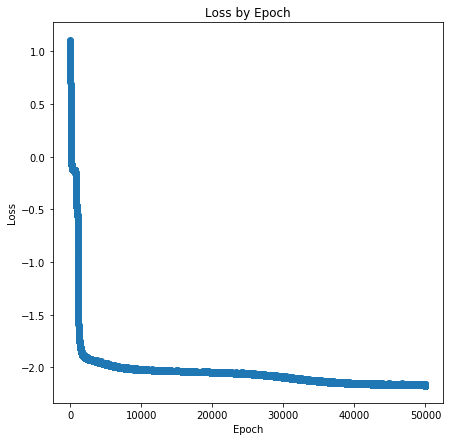

In [128]:
# plotting epoch losses
plt.figure(figsize=(7, 7))
plt.plot(np.arange(50000), epoch_loss_list, 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by Epoch')
plt.show()

**C3**: Plot the MLE parameters against x. Make a plot similar to B3 above where you overlay the "means" of the gaussians against the data.

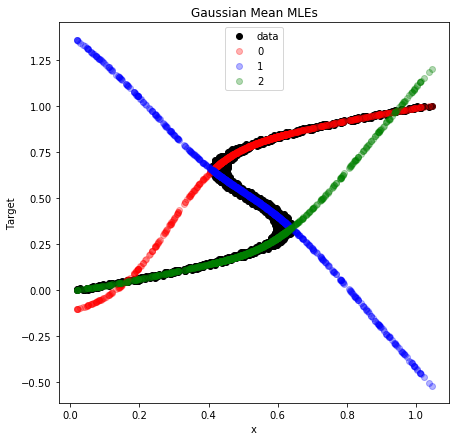

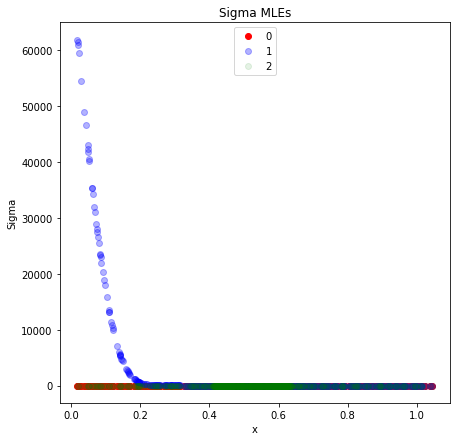

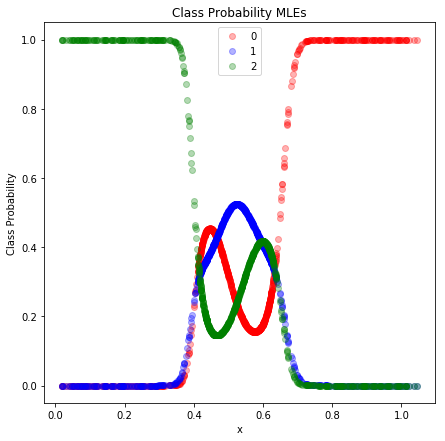

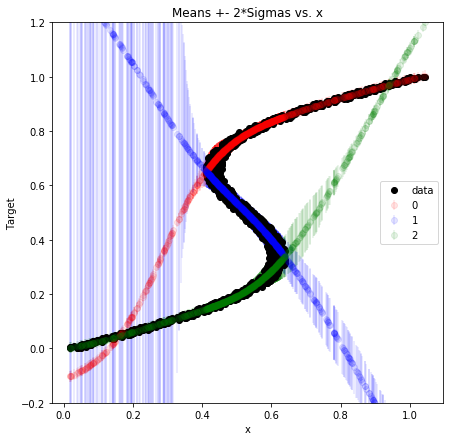

In [138]:
# plotting MLEs against x
pi, sigma, mu = network(Variable(torch.from_numpy(df.x.values.reshape(len(df), -1))).float())
plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black')
plt.plot(df.x.values, mu.data.numpy()[:, 2], 'o', alpha = 0.3, color='red')
plt.plot(df.x.values, mu.data.numpy()[:, 1], 'o', alpha = 0.3, color='blue')
plt.plot(df.x.values, mu.data.numpy()[:, 0], 'o', alpha = 0.3, color='green')
plt.legend(loc='upper center', labels=['data', 0, 1, 2])
plt.xlabel('x')
plt.ylabel('Target')
plt.title('Gaussian Mean MLEs')
plt.show()
plt.figure(figsize=(7, 7))
plt.plot(df.x.values, sigma.data.numpy()[:, 2], 'o', alpha = 1.0, color='red')
plt.plot(df.x.values, sigma.data.numpy()[:, 1], 'o', alpha = 0.3, color='blue')
plt.plot(df.x.values, sigma.data.numpy()[:, 0], 'o', alpha = 0.1, color='green')
plt.legend(loc='upper center', labels=[0, 1, 2])
plt.xlabel('x')
plt.ylabel('Sigma')
plt.title('Sigma MLEs')
plt.show()
plt.figure(figsize=(7, 7))
plt.plot(df.x.values, pi.data.numpy()[:, 2], 'o', alpha = 0.3, color='red')
plt.plot(df.x.values, pi.data.numpy()[:, 1], 'o', alpha = 0.3, color='blue')
plt.plot(df.x.values, pi.data.numpy()[:, 0], 'o', alpha = 0.3, color='green')
plt.legend(loc='upper center', labels=[0, 1, 2])
plt.xlabel('x')
plt.ylabel('Class Probability')
plt.title('Class Probability MLEs')
plt.show()

# plotting like b3
plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black', label='data')
plt.errorbar(df.x.values, mu.data.numpy()[:, 2], yerr = 2*sigma.data.numpy()[:, 2], fmt='o', color='red', alpha=0.1, label=0)
plt.errorbar(df.x.values, mu.data.numpy()[:, 1], yerr = 2*sigma.data.numpy()[:, 1], fmt='o', 
             color='blue', alpha=0.1, label=1)
plt.errorbar(df.x.values, mu.data.numpy()[:, 0], yerr = 2*sigma.data.numpy()[:, 0], fmt='o', 
             color='green', alpha=0.1, label=2)
plt.title('Means +- 2*Sigmas vs. x')
plt.xlabel('x')
plt.ylabel('Target')
plt.ylim(-0.2, 1.2)
plt.legend(loc='center right')
plt.show()

**C4**: Sample from the sampling distributions to make a plot similar to B5 above

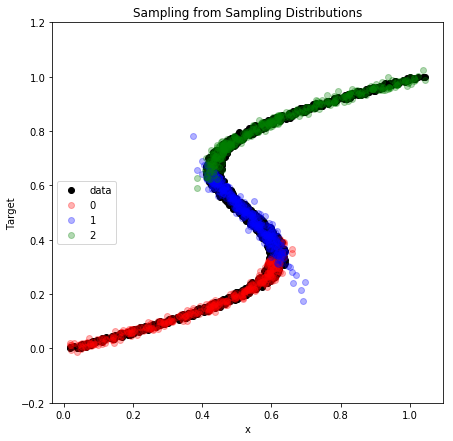

In [132]:
# sampling from sampling distributions
np.random.seed(1)
class_nums = []
pred_mat = np.zeros((len(df), 3))
for i in range(len(df)):
    gaussian_draw0 = np.random.normal(loc=mu.data.numpy()[i,0], scale=sigma.data.numpy()[i,0])
    gaussian_draw1 = np.random.normal(loc=mu.data.numpy()[i,1], scale=sigma.data.numpy()[i,1])
    gaussian_draw2 = np.random.normal(loc=mu.data.numpy()[i,2], scale=sigma.data.numpy()[i,2])
    gaussian_draws = np.array([gaussian_draw0, gaussian_draw1, gaussian_draw2])
    pi.data.numpy()[i,:][pi.data.numpy()[i,:] < 0.00001] = 0
    classes_ind = np.random.multinomial(n=1, pvals=pi.data.numpy()[i,:])
    pred_mat[i, :] = gaussian_draws*classes_ind
    class_num = np.argmax(classes_ind)
    class_nums.append(class_num)
class_nums = np.array(class_nums)

class_df = np.concatenate([df.values, class_nums.reshape(len(df), -1)], axis=1)
x_class0 = class_df[class_df[:, 2] == 0, 1]
x_class1 = class_df[class_df[:, 2] == 1, 1]
x_class2 = class_df[class_df[:, 2] == 2, 1]
pred0 = pred_mat[class_df[:, 2] == 0, 0]
pred1 = pred_mat[class_df[:, 2] == 1, 1]
pred2 = pred_mat[class_df[:, 2] == 2, 2]

plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black')
plt.plot(x_class0, pred0, 'o', color='red', alpha=0.3)
plt.plot(x_class1, pred1, 'o', color='blue', alpha=0.3)
plt.plot(x_class2, pred2, 'o', color='green', alpha=0.3)
plt.title('Sampling from Sampling Distributions')
plt.xlabel('x')
plt.ylabel('Target')
plt.ylim(-0.2, 1.2)
plt.legend(loc='center left', labels=['data', 0, 1, 2])
plt.show()

## Part D Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part C in directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**D1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

In [261]:
# define model
x = theano.shared(df.x.values.reshape(len(df), -1))
target = theano.shared(df.target.values)
n_hidden = 20

np.random.seed(1)
init_input_h = np.random.randn(1, n_hidden)
init_h_target = np.random.randn(1, 3)
init_h_class = np.random.randn(1, 3)
init_h_sigma = np.random.randn(1, 3)

with pm.Model() as vmdn:
    
    # weights from input to hidden and hidden to output
    w_input_h = pm.Normal('w_input_h', mu=0, sd=5, shape=(1, n_hidden), testval=init_input_h)
    w_h_target = pm.Normal('w_h_target', mu=0, sd=5, shape=(n_hidden, 3), testval=init_h_target)
    w_h_class = pm.Normal('w_h_class', mu=0, sd=5, shape=(n_hidden, 3), testval=init_h_class)
    w_h_sigma = pm.Normal('w_h_sigma', mu=0, sd=5, shape=(n_hidden, 3), testval=init_h_sigma)
    
    # biases for input to hiddena and hidden to output
    b_input_h = pm.Normal('b_input_h', mu=0, sd=5, shape=(1, n_hidden))
    b_h_target = pm.Normal('b_h_target', mu=0, sd=5, shape=(1, 3))
    b_h_class = pm.Normal('b_h_class', mu=0, sd=5, shape=(1, 3))
    b_h_sigma = pm.Normal('b_h_sigma', mu=0, sd=5, shape=(1, 3))

    # tanh activation
    h_act = pm.Deterministic('h', T.tanh(T.dot(x, w_input_h) + b_input_h))
    
    # outputs
    act_target = pm.Deterministic('means', T.dot(h_act, w_h_target) + b_h_target)
    act_class = pm.Deterministic('probs', T.nnet.softmax(T.dot(h_act, w_h_class) + b_h_class))
    act_sigma = pm.Deterministic('sigmas', T.exp(T.dot(h_act, w_h_sigma) + b_h_sigma) + 0.01)
    
    obs = pm.NormalMixture('obs', w=act_class, mu=act_target, sd=act_sigma, observed=target)

In [262]:
# fit model variationally
with vmdn:
    inference_nn = pm.ADVI()
    approx_nn = pm.fit(n=100000, method=inference_nn, obj_optimizer=pm.adam(learning_rate=0.01))
    nn_trace = approx_nn.sample(draws=5000)

INFO (theano.gof.compilelock): Refreshing lock /home/chris/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.3-64/lock_dir/lock
Average Loss = -160.98: 100%|██████████| 100000/100000 [06:41<00:00, 249.08it/s] 
Finished [100%]: Average Loss = -161.33
INFO (theano.gof.compilelock): Refreshing lock /home/chris/.theano/compiledir_Linux-4.13--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.3-64/lock_dir/lock


**D2**: Sample from the posterior predictive as you did in B4 and produce a diagram like C4 and B5 for this model.

In [188]:
# sampling from posterior predictive
means0 = pm.summary(nn_trace)['mean'][210:3210][::3].values
means1 = pm.summary(nn_trace)['mean'][211:3211][::3].values
means2 = pm.summary(nn_trace)['mean'][212:3212][::3].values

sigmas0 = pm.summary(nn_trace)['mean'][6210:][::3].values
sigmas1 = pm.summary(nn_trace)['mean'][6211:][::3].values
sigmas2 = pm.summary(nn_trace)['mean'][6212:][::3].values

probs0 = pm.summary(nn_trace)['mean'][3210:6210][::3].values
probs1 = pm.summary(nn_trace)['mean'][3211:6211][::3].values
probs2 = pm.summary(nn_trace)['mean'][3212:6212][::3].values

np.random.seed(1)
class_nums = []
pred_mat = np.zeros((len(df), 3))
for i in range(len(df)):
    gaussian_draw0 = np.random.normal(loc=means0[i], scale=sigmas0[i])
    gaussian_draw1 = np.random.normal(loc=means1[i], scale=sigmas1[i])
    gaussian_draw2 = np.random.normal(loc=means2[i], scale=sigmas2[i])
    gaussian_draws = np.array([gaussian_draw0, gaussian_draw1, gaussian_draw2])
    classes_ind = np.random.multinomial(n=1, pvals=[probs0[i], probs1[i], probs2[i]])
    pred_mat[i, :] = gaussian_draws*classes_ind
    class_num = np.argmax(classes_ind)
    class_nums.append(class_num)
class_nums = np.array(class_nums)

class_df = np.concatenate([df.values, class_nums.reshape(len(df), -1)], axis=1)
x_class0 = class_df[class_df[:, 2] == 0, 1]
x_class1 = class_df[class_df[:, 2] == 1, 1]
x_class2 = class_df[class_df[:, 2] == 2, 1]
pred0 = pred_mat[class_df[:, 2] == 0, 0]
pred1 = pred_mat[class_df[:, 2] == 1, 1]
pred2 = pred_mat[class_df[:, 2] == 2, 2]

plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black')
plt.plot(x_class2, pred2, 'o', color='red', alpha=0.3)
plt.plot(x_class1, pred1, 'o', color='blue', alpha=0.3)
plt.plot(x_class0, pred0, 'o', color='green', alpha=0.3)
plt.title('Sampling from Posterior Predictive')
plt.xlabel('x')
plt.ylabel('Target')
plt.ylim(-0.2, 1.2)
plt.legend(loc='center left', labels=['data', 0, 1, 2])
plt.show()

IndexError: index 950 is out of bounds for axis 0 with size 950

**D3**: Plot the "mean" regression curves (similar to C3 and B3). Do the "mean" regression curves in this model look the same from those in Part C?  If they differ why so?

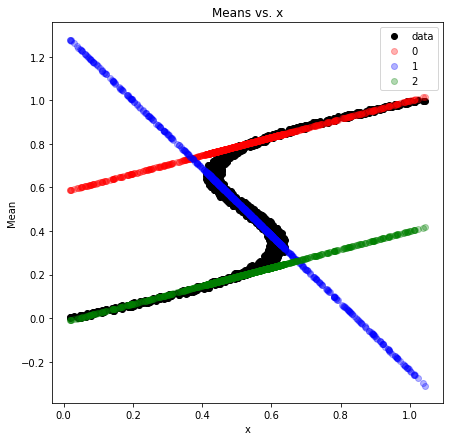

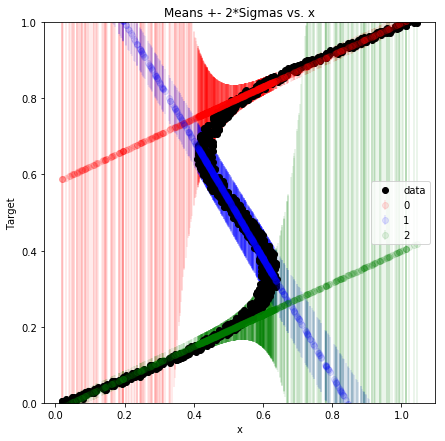

In [155]:
plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black', label='data')
plt.plot(df.x.values, means2, 'o', color='red', label=0, alpha=0.3)
plt.plot(df.x.values, means1, 'o', color='blue', label=1, alpha=0.3)
plt.plot(df.x.values, means0, 'o', color='green', label=2, alpha=0.3)
plt.xlabel('x')
plt.ylabel('Mean')
plt.title('Means vs. x')
plt.legend(loc='upper right')
plt.show()

# plotting like above
plt.figure(figsize=(7, 7))
plt.plot(df.x.values, df.target.values, 'o', color='black', label='data')
plt.errorbar(df.x.values, means2, yerr = 2*sigmas2, fmt='o', color='red', alpha=0.1, label=0)
plt.errorbar(df.x.values, means1, yerr = 2*sigmas1, fmt='o', color='blue', alpha=0.1, label=1)
plt.errorbar(df.x.values, means0, yerr = 2*sigmas0, fmt='o', color='green', alpha=0.1, label=2)
plt.title('Means +- 2*Sigmas vs. x')
plt.xlabel('x')
plt.ylabel('Target')
plt.ylim(0, 1)
plt.legend(loc='center right')
plt.show()

## Part E: Approximate EM for model in part B (EXTRA CREDIT)

Part B can be implemented using Expectation Maximization using iteratively-reweighted least squares. Our method in A was merely an approximation to this process. You can find update equations [here](https://people.eecs.berkeley.edu/~jordan/papers/jordan-xu.ps)